# ASTR 596 Computer lab - Image combination and photometry (50 points)

In this lab you will learn how to:
* combine a set of astrometrically aligned images
* measure the size of stars in each of these images
* measure fluxes of objects in each image
* convert these to magnitudes
* match sources in the two catalogs
* plot H-R diagrams for the cluster

<i>Note: Enter in all code to the problems in the provided notebook cells. Questions to answer will be <b>bolded</b>.</i>  

All your answers should be entered in this notebook. Each student will need to hand in their own notebook by uploading it to GitHub following the instructions.

In the code places where you will need to put something or write your own code are specified by `#***************`  You will not get points for doing this unless explicitly noted.  Some of these things are just to make sure you are setting up your paths correctly.

**Due on Nov. 18 at Noon** to be handed into the "Image Combinaton and Photometry" assignment in Module 8.

Thanks to Prof. Rose Finn for her work in reducing the individual images of M29 and for providing them to us.

**You will need to download the raw data.  You can access it at**

**https://www.dropbox.com/t/wqpOzykI2Q9vznIF**

I suggest you make a directory on your computer called `~/ASTR596/Data` and put data in there.  

In [1]:
from photutils.detection import DAOStarFinder
from astropy.stats import sigma_clipped_stats
from photutils.aperture import CircularAperture
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from astropy.wcs import WCS
from astropy.io import fits
import glob
import os
from scipy.stats import scoreatpercentile

from matplotlib import pyplot as plt
import numpy as np

#import ccdproc

from astropy.nddata import CCDData
import astropy.units as u
from ccdproc import ImageFileCollection, Combiner, combine
from ccdproc import wcs_project


### Some functions to display the images and overplot the stars

In [2]:
def imdisplay(image, v1perc=10, v2perc=95):
    '''
    display an image 
    OPTIONAL KEYWORD PARAMETERS
    v1perc: one end of the colormap assigned to the v1perc percent lowest flux 
    v2perc: the other end of the colormap assigned to the v2perc percent highest flux    
    '''
    # make sure image is an np array
    nimage = np.array(image)
    # determine the pixel values at the 10th and 95th percentile
    v1 = scoreatpercentile(nimage,v1perc)
    v2 = scoreatpercentile(nimage,v2perc)
    # display using imshow
    #
    # you can play with alternate cmaps in the function below, such as "viridis" or "gray"
    # The 'gray_r' color map reverses the color-scale so that dark display pixels are the brightest in the image
    #
    # vmin and vmax set the min and max pixel values that
    # will be mapped to the extremes of the colormap
    plt.imshow(nimage,cmap='gray_r',vmin=v1,vmax=v2)
    plt.colorbar(fraction=.08)
    
def add_stars(xstars,ystars,radius=20,color='r',ax=None):
    ''' this will add circles at the location of xstars,ystars '''
    if ax is None:
        ax = plt.gca()
    allcircles=[]
    #The zip function takes iterables (e.g. lists or arrays) and groups them into tuples that contain 
    #matched pairs of each input, e.g [(x,y)]
    for x,y in zip(xstars,ystars):
        c = plt.Circle((x,y),radius,color=color,fill=False)
        #allcircles.append(c)
        ax.add_artist(c)

In [3]:
#set the directory with your data
#*********************
#you will need to modify this with your own directory
datadir = '/home/m364e711/ASTR596/Data/M29_cal'

#change directory to the data directory
os.chdir(datadir)


### Display one image in each filter 
This will let you see what the data in each filter looks like.  There are multiple images taken in each band.  The following blocks of code each display the first image taken in each band.

Text(0.5, 1.0, 'B-band image')

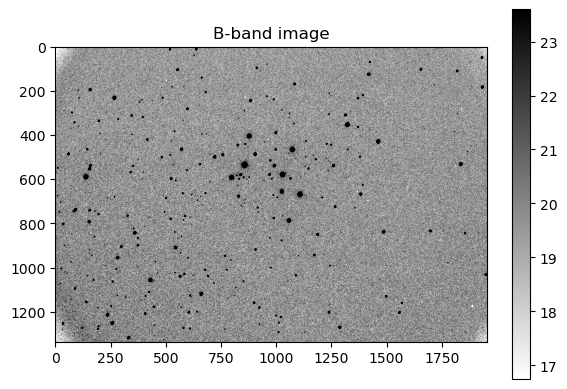

In [4]:
#make the figure
plt.figure()

#read in the data and header
data,header = fits.getdata('cazfdp-M29-0001b.fits', header=True)

#use our custom made subroutine from above to plot the image
imdisplay(data)
plt.title("B-band image")

Text(0.5, 1.0, 'V-band image')

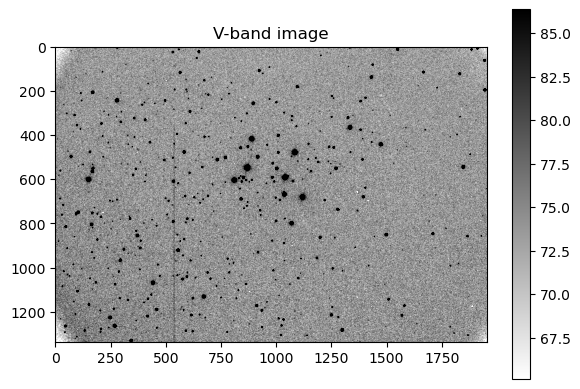

In [5]:
#make the figure
plt.figure()

#read in the data and header
data,header = fits.getdata('cazfdp-M29-0001g.fits', header=True)

#use our custom made subroutine from above to plot the image
imdisplay(data)
plt.title("V-band image")

Text(0.5, 1.0, 'R-band image')

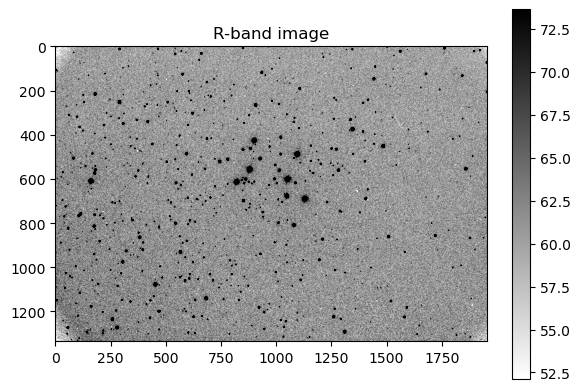

In [6]:
#make the figure
plt.figure()

#read in the data and header
data,header = fits.getdata('cazfdp-M29-0001r.fits', header=True)

#use our custom made subroutine from above to plot the image
imdisplay(data)
plt.title("R-band image")

### determine how subsequent images in a single band differ

Use ds9 to display the 0001, 0002, and 0003 images for the $B$ band.  Display each image in a separate frame by creating a new frame in the horizontal button bar and opening the file into that frame.  Use the `scale->zscale` button to display the stretch better.

By hitting the Tab key you can cycle through the images.  Shift-Tab cycles through them in reverse order.  You can also use the Blink button or the Tile button under the Frame button to blink the images.

### Problem 1 (6 points)
What is the main difference between the different individual images within a single band?  Be quantitative whenever possible.

**put answer here**: The main difference between the individual images that one can qualitatively see is that the objects in the image shift their positions in the frame. They don't move relative to each other, but they do change positions when they are displayed. Something else that changes is the values on the color bar at the bottom of the ds9 screen. The 0001 image has the lowest values in each interval of spacing on the colorbar, compared to the values in each interval of spacing on the colorbars of 0002 and 0003, respectively. 

### Combine the images in each filter.

Reference: https://ccdproc.readthedocs.io/en/latest/image_combination.html

Note: $BVR$ images have extensions $bgr$ in our data set.  These images have had their bias correction, dark current, flatfielding, astrometry, and photometric zeropoint all measured and have had cosmicrays removed.

We will use a new task called `glob.glob` which finds all the files in a current directory that match a certain syntax.

The image combination has multiple steps
* get a list of the images in each band.  
* Each image has a slightly different pointing because the telescope was dithered around.
* establish which WCS you will use as a target onto which all the other images will be aligned.
* use a task called `reproject` to align all of the images using the reference
* Students will need to write code to combine 2 of the 3 sets of images.


In [7]:
#for example, to get a list of all the images
image_list = glob.glob('ca*.fits')
print(image_list)

['cazfdp-M29-0004b.fits', 'cazfdp-M29-0002g.fits', 'cazfdp-M29-0005b.fits', 'cazfdp-M29-0003r.fits', 'cazfdp-M29-0002b.fits', 'cazfdp-M29-0003g.fits', 'cazfdp-M29-0005r.fits', 'cazfdp-M29-0004r.fits', 'cazfdp-M29-0001g.fits', 'cazfdp-M29-0001r.fits', 'cazfdp-M29-0005g.fits', 'cazfdp-M29-0001b.fits', 'cazfdp-M29-0003b.fits', 'cazfdp-M29-0002r.fits', 'cazfdp-M29-0004g.fits']


In [9]:
#*****************
#Using the above code as a reference, create lists of images in each band
#First we need to get a list for images in each filter
rimage_list = glob.glob('*r.fits') #using the * creates a wildcard that searches for and finds every image with the phrase 'r.fits' in it
gimage_list = glob.glob('*g.fits')
bimage_list = glob.glob('*b.fits')

#read in the first r-band image in that list using fits.getdata.  This image will be used as a target whose WCS
# will be used for all other images to be transformed onto
rimage, rheader = fits.getdata(rimage_list[0],header=True)
target_wcs = WCS(header)

print(target_wcs)
#**********************
#now print out each of the image lists to see if they make sense
print(rimage_list) #prints out rimage_list
print(gimage_list)
print(bimage_list)


WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP' 'DEC--TAN-SIP' 
CRVAL : 305.979554574 38.5221094171 
CRPIX : 977.5 668.5 
CD1_1 CD1_2  : 0.000213779024462 -6.70567456134e-05 
CD2_1 CD2_2  : 6.71084281872e-05 0.000213787720685 
NAXIS : 1954  1336
['cazfdp-M29-0003r.fits', 'cazfdp-M29-0005r.fits', 'cazfdp-M29-0004r.fits', 'cazfdp-M29-0001r.fits', 'cazfdp-M29-0002r.fits']
['cazfdp-M29-0002g.fits', 'cazfdp-M29-0003g.fits', 'cazfdp-M29-0001g.fits', 'cazfdp-M29-0005g.fits', 'cazfdp-M29-0004g.fits']
['cazfdp-M29-0004b.fits', 'cazfdp-M29-0005b.fits', 'cazfdp-M29-0002b.fits', 'cazfdp-M29-0001b.fits', 'cazfdp-M29-0003b.fits']


###  Combine the images

Text(0.5, 1.0, 'R-band image')

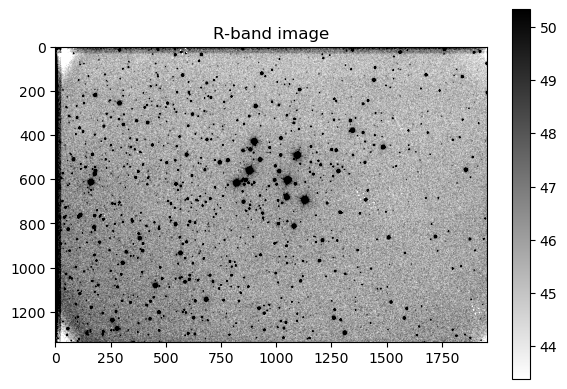

In [12]:
# We will reproject all the images to align them with the first image in each of the lists for a given filter.
#start with the R-band data
reprojected_r = []
#loop through each image name
for image_name in rimage_list:
    #read the image into a "CCDData" object
    img = CCDData.read(image_name)
    #take each image, astropyand reproject it onto an identical coordinate grid to the target image
    new_image = wcs_project(img, target_wcs)
    #this is a list of all the reprojected images
    reprojected_r.append(new_image)

# combine the reprojected images into one image
combiner = Combiner(reprojected_r)
stacked_image = combiner.average_combine()


# save the combined image
fits.writeto('M29R.fits',stacked_image,overwrite=True,header=rheader)
# display the combined image
plt.figure()
imdisplay(stacked_image)
plt.title('R-band image')

## Problem 2a (4 points) - combine exposures for the G and B-band images

You must new repeat this for the G and B-band images and trim all three images to remove bad data at the edges of the image.

/home/m364e711/micromamba/envs/stenv/lib/python3.12/site-packages/ccdproc/combiner.py:548: RuntimeWarning: Mean of empty slice
  mean = scale_func(data, axis=0)
/home/m364e711/micromamba/envs/stenv/lib/python3.12/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Text(0.5, 1.0, 'G-band image')

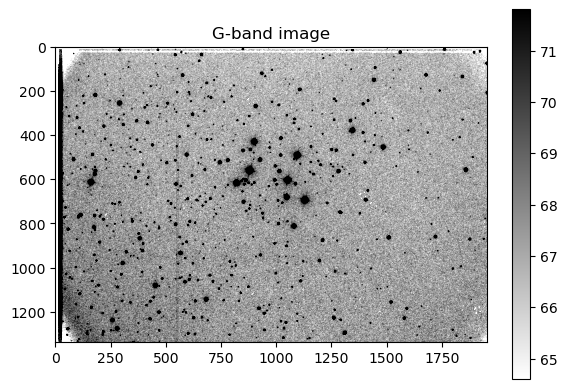

In [13]:
#*********************
#repeat for the G-band images

gimage, gheader = fits.getdata(gimage_list[0], header=True) #combines the reprojected images into one image
target_wcs_g = WCS(header)

# We will reproject all the images to align them with the first image in each of the lists for a given filter.
#G-band data
reprojected_g = [] #creates blank array
#loop through each image name
for image_name in gimage_list:
    #read the image into a "CCDData" object
    img = CCDData.read(image_name)
    #take each image, and reproject it onto an identical coordinate grid to the target image
    new_image = wcs_project(img, target_wcs)
    #this is a list of all the reprojected images
    reprojected_g.append(new_image)

# combine the reprojected images into one image
combiner_g = Combiner(reprojected_g) #'_g' added so it's a different variable than the combiner in the r-band
stacked_image_g = combiner_g.average_combine()


# save the combined image
fits.writeto('M29G.fits',stacked_image_g,overwrite=True,header=gheader)
# display the combined image
plt.figure()
imdisplay(stacked_image_g)
plt.title('G-band image')

/home/m364e711/micromamba/envs/stenv/lib/python3.12/site-packages/ccdproc/combiner.py:548: RuntimeWarning: Mean of empty slice
  mean = scale_func(data, axis=0)
/home/m364e711/micromamba/envs/stenv/lib/python3.12/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Text(0.5, 1.0, 'B-band image')

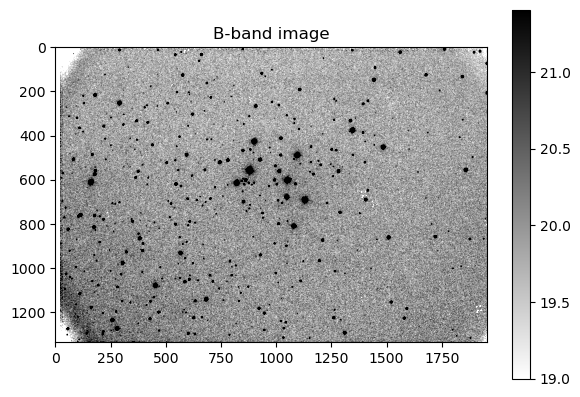

In [14]:
#*********************
#repeat for the B-band images

bimage, bheader = fits.getdata(bimage_list[0], header=True)
target_wcs_b = WCS(header)

# We will reproject all the images to align them with the first image in each of the lists for a given filter.
#B-band data
reprojected_b = []
#loop through each image name
for image_name in bimage_list:
    #read the image into a "CCDData" object
    img = CCDData.read(image_name)
    #take each image, and reproject it onto an identical coordinate grid to the target image
    new_image = wcs_project(img, target_wcs)
    #this is a list of all the reprojected images
    reprojected_b.append(new_image)

# combine the reprojected images into one image
combiner_b = Combiner(reprojected_b) #'_b' added to differentiate this variable from the r and b combiners
stacked_image_b = combiner_b.average_combine()


# save the combined image
fits.writeto('M29B.fits',stacked_image_b,overwrite=True,header=bheader)
# display the combined image
plt.figure()
imdisplay(stacked_image_b)
plt.title('B-band image')

## Problem 2b (2 points) - How would you remove cosmicrays?

Assume that there are some cosmicrays in each of the individual images in each band.  Using the manual for image combnination that is linked to right after problem one, describe how you would alter the code above to reject cosmicrays as part of the combination.  You may try to combine the images with this method.

**put answer here**: One way to reject cosmic rays would be to use sigma clipping. Because cosmic rays have pixel values much higher than the rest of the pixels, if you use the sigma clipping method you can remove any pixel a number of standard deviations higher or lower than the median. For example, you could remove any pixels 5 standard deviations away from the median using the following:

>>>combiner.sigma_clipping(high_thresh=5, func=np.ma.median)

### What if we want to display our images using RA and DEC?

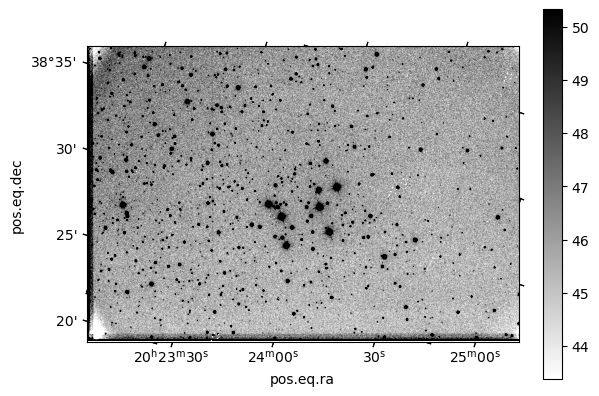

In [15]:
plt.subplot(projection=target_wcs)
imdisplay(stacked_image)

## Problem 3 - Measure the FWHM of stars using imexam (6 points)

imexam is a powerful image quick look tool to examine the images.  More info is at https://imexam.readthedocs.io/en/0.9.1/index.html

As it is a finiky package, to use it we will need to make a new environment.  You should do so with the following command from a new prompt that is in your base conda environment:

`micromamba create --name env1 python==3.8 astropy==5.2.2 imexam=0.9.1 ipython --channel conda-forge `

This environment will only be used with imexam.

In at terminal in the same directory as your data type `ipython`.  At the ipython command line type the following commands, each on their own line
* import imexam
* viewer=imexam.connect()   #start a ds9 window
* viewer.load_fits('M29B.fits')  #loads an image
* viewer.scale()   #change to the default zscale
* viewer.imexam() #start the interactive tool.

You will see a set of cursor commands.  By putting the cursor over a star in the image and hitting the `a` key you will get a measure of the FWHM in the image.  Sometimes you will get an error about the plot window timing out.  If you click back on the DS9 window you should be able to hit the key again.

Do this for 5 bright but unsaturated stars in each image and take the average to get the FWHM of your image.  Note that imexam outputs the FWHM in pixels.  You can use the `r` key in imexam to print a radial profile that you can use to see if the image is saturated.  **Don't trust the FWHM from the radial plot.  I don't think it is correct.**

Fill in those values below


FWHM of B-band image (in pix): 

FWHM of V-band image (in pix): 

## Problem 4 - Measure the photometry of the stars using photutils (8 points) 

DAOStarFinder is a program that detects objects in images using the same method we talked about in class.

In addition to writing the code for this section, I also want you to make a plot of the number of detected sources for different values of the "threshold" parameter in DAOStarFinder.  Do this for The B and V-bands and and comment on how the behavior of the number of sources depends on the threshold value for each band.

In [50]:
#read in the B-band image
data_b, header_b = fits.getdata('M29B.fits',header=True)
#print(header_b["NAXIS1"])

1954


In [23]:
# estimate the background counts in the image by computing the 
# mean and median excluding all pixels greater than 3-sigma above the mean
mean_b, median_b, std_b = sigma_clipped_stats(data_b, sigma=3.0)

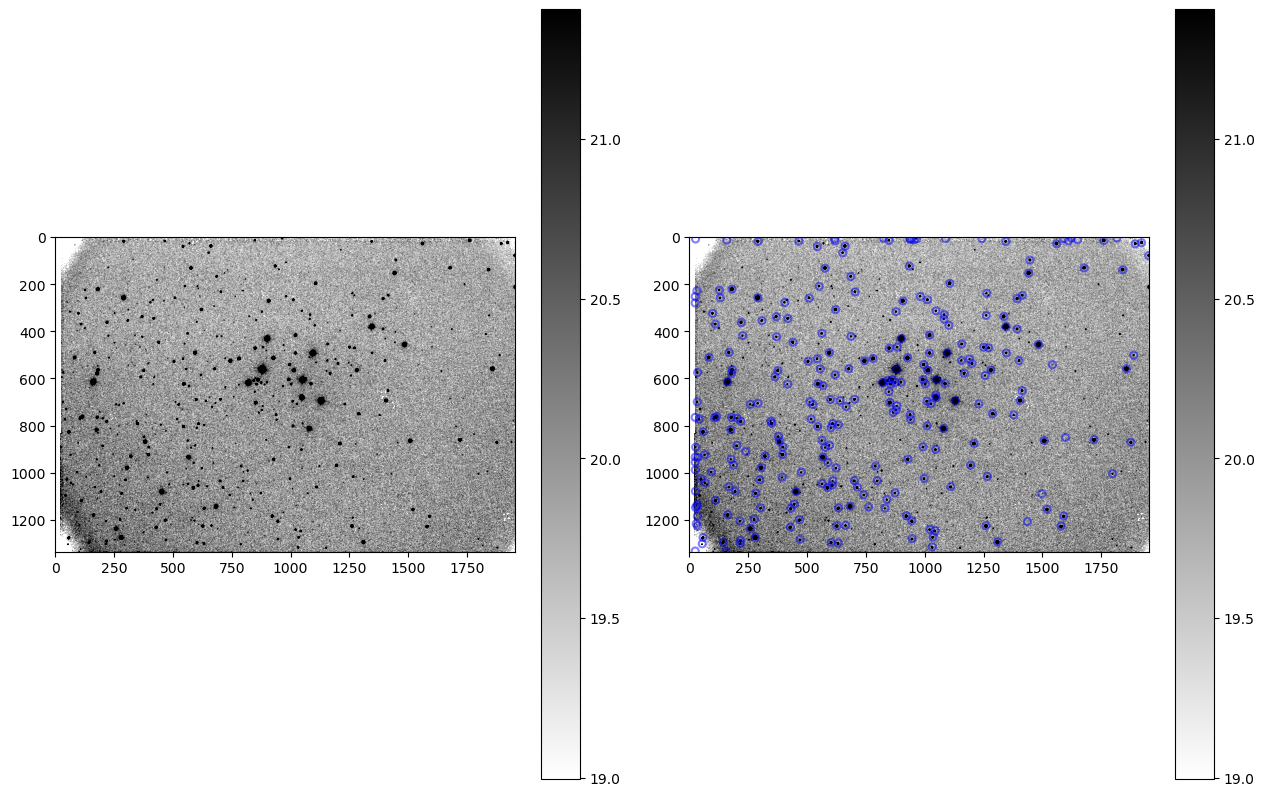

In [39]:
# set up daofind, with info about our image fwhm and the detection threshold
#*****************************************
# update with the FWHM that you measured from the imexam.  
#Use the value below until we get imexam working, or develop an alternative
daofind = DAOStarFinder(fwhm=2.7, threshold=5.*std_b)

# detect sources, using the image - median, which subtracts the sky level from image, 
# assuming a sky that is constant across the iamge
sources_b = daofind(data_b - median_b)

# convert pixel locations of images to ra and dec using the image header
wcs_b = WCS(header_b)
ra_b,dec_b = wcs_b.wcs_pix2world(sources_b['xcentroid'],sources_b['ycentroid'],0)

# plot images and the sources.  using the subplot command we can plot figures side by side
#plots B-band image
plt.figure(figsize=(15,10))
#select the left plot
plt.subplot(1,2,1)
imdisplay(data_b)

#plot B-band image with the positions of the sources overlaid
#select the right plot
plt.subplot(1,2,2)

#Create a list of positions of all the stars, as determined by the DAOStarFinder above.  
#The transpose command puts the images into the correct format
positions = np.transpose((sources_b['xcentroid'], sources_b['ycentroid']))
#creates a set of circular apertues with r=15 pixels
apertures = CircularAperture(positions, r=15.)
imdisplay(data_b)
#plot the apertures.  the ';' at the end suppresses some messy output
apertures.plot(color='blue', lw=1.5, alpha=0.5);

1954
1336


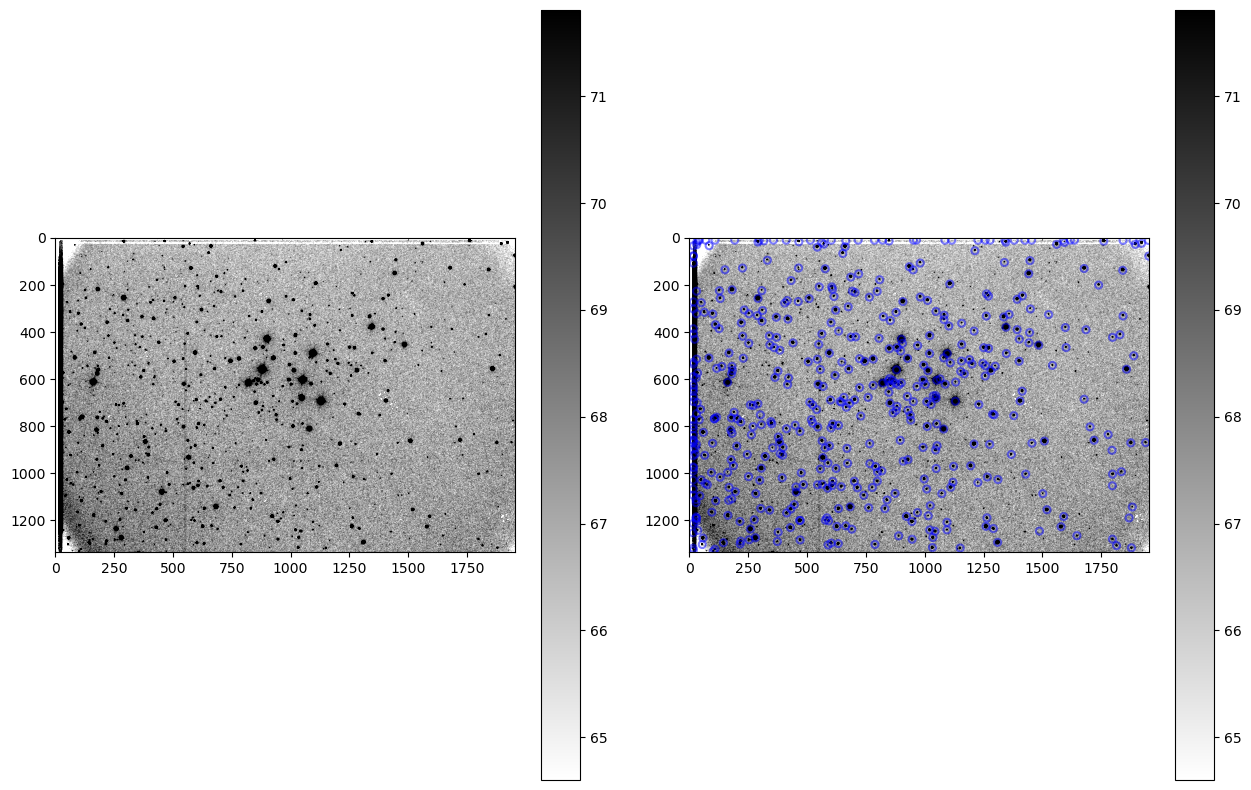

In [54]:
#********************
#repeat for the G-band image
#put your code here

#read in the G-band image
data_g, header_g = fits.getdata('M29G.fits',header=True) #'_g' ending added to all new variables so they stay seperate from all the b-band image variables
print(header_g["NAXIS1"])
print(header_g["NAXIS2"])
# estimate the background counts in the image by computing the 
# mean and median excluding all pixels greater than 3-sigma above the mean
mean_g, median_g, std_g = sigma_clipped_stats(data_g, sigma=3.0)

# set up daofind, with info about our image fwhm and the detection threshold
#*****************************************
# update with the FWHM that you measured from the imexam.  
#Use the value below until we get imexam working, or develop an alternative
daofind_g = DAOStarFinder(fwhm=2.7, threshold=5.*std_g)

# detect sources, using the image - median, which subtracts the sky level from image, 
# assuming a sky that is constant across the iamge
sources_g = daofind_g(data_g - median_g)

# convert pixel locations of images to ra and dec using the image header
wcs_g = WCS(header_g)
ra_g,dec_g = wcs_g.wcs_pix2world(sources_g['xcentroid'],sources_g['ycentroid'],0)

# plot images and the sources.  using the subplot command we can plot figures side by side
#plots G-band image
plt.figure(figsize=(15,10))
#select the left plot
plt.subplot(1,2,1)
imdisplay(data_g)

#plot G-band image with the positions of the sources overlaid
#select the right plot
plt.subplot(1,2,2)

#Create a list of positions of all the stars, as determined by the DAOStarFinder above.  
#The transpose command puts the images into the correct format
positions_g = np.transpose((sources_g['xcentroid'], sources_g['ycentroid']))
#creates a set of circular apertues with r=15 pixels
apertures_g = CircularAperture(positions_g, r=15.)
imdisplay(data_g)
#plot the apertures.  the ';' at the end suppresses some messy output
apertures_g.plot(color='blue', lw=1.5, alpha=0.5);

## Problem 5 - Compare the positions of the V and B-band sources (6 points)

* Make a plot of the DEC vs RA of the sources in the B and V images.
* Plot each set with a separate marker.
* <font color='red'> answer the question </font> Are the same sources detected in each image?  If not, which images has more sources and why?
* When plotting, you need to use boolean arrays to select sources that are more than 50 pixels away from the edges of each image.  This will prevent you from plotting sources that have been measured from parts of the image with bad data.


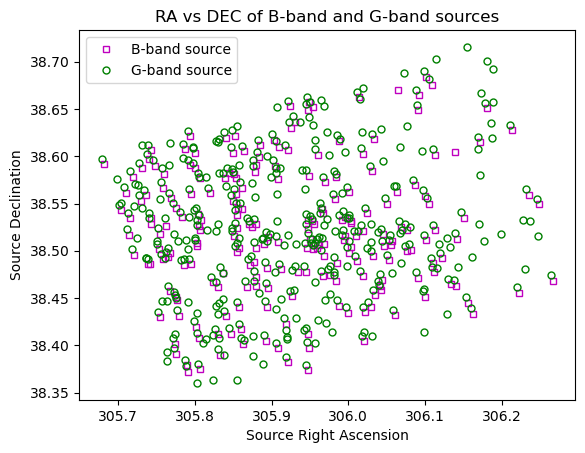

In [57]:
#*************************
# make a plot of the RA and DEC of the sources in the B and V images

#select sources away from image boundary in B-band image
#boolean flags for good positions in the B and V-band images
noedgeflag_b = (sources_b['xcentroid'] > 50) & (sources_b['xcentroid'] < 1904) & (sources_b['ycentroid'] > 50) & (sources_b['ycentroid'] < (1336 - 50))
noedgeflag_g = (sources_g['xcentroid'] > 50) & (sources_g['xcentroid'] < 1904) & (sources_g['ycentroid'] > 50) & (sources_g['ycentroid'] < (1336 - 50))

# open a figure
plt.figure()

# plot the positions of the B sources
plt.plot(ra_b[noedgeflag_b], dec_b[noedgeflag_b], 'ms',mfc='None',markersize=5,label='B-band source')

# plot the positions of the G sources
plt.plot(ra_g[noedgeflag_g], dec_g[noedgeflag_g], 'g.', mfc='None',markersize=10, label='G-band source')

# add a legend
plt.legend()

#add a title
plt.title("RA vs DEC of B-band and G-band sources")

# label your x axis
plt.xlabel("Source Right Ascension")

# label your y axis
plt.ylabel("Source Declination")

# save your plot
plt.savefig("b-band_and_g-band_sources.png")

For the most part, the two bands plot many of the same sources. The g-band plots many more sources than the b-band, and the g-band plots nearly every source that the g-band plots. This is because the g-band detected more sources, showing that within the wavelengths of the g-band more sources were able to be detected. Only a few sources in the b-band were plotted than the g-band did not also plot.

## Match the catalogs of the B and V photometry

We can match the sources in the two catalogs using their RA and DEC

In [58]:
from astropy.coordinates import SkyCoord
from astropy import units as u

In [59]:
#this creates a SkyCoord object containing the B and V catalogs
b_catalog = SkyCoord(ra=ra_b*u.degree, dec=dec_b*u.degree)
g_catalog = SkyCoord(ra=ra_g*u.degree, dec=dec_g*u.degree)

#this matches the two catalogs and outputs an array of indices, idx that when passed to v_catalog
#gives the ids of the match sources in the b_catalog.
idx, d2d, d3d = b_catalog.match_to_catalog_sky(g_catalog)

# we are going to keep matches that have offsets less than 5 arcseconds
# NOTE: this might not be small enough if you were
# matching stars in a globular cluster
matchflag = d2d < 5./3600*u.deg
bmag = sources_b['mag'][matchflag]
gmag = sources_g['mag'][idx[matchflag]]

print(bmag)
print(gmag)

         mag         
---------------------
  -2.4135747719435865
 -0.07595439419240144
  -3.5372114699351656
  -0.0895861525435786
  -1.9928524066826523
 -0.06777018124364068
-0.054182255352893005
 -0.03376521004522375
        mag         
--------------------
-0.21259407664705718
-0.07757196573334199
-0.49510335394687915
 -0.6785171547985152
 -2.0592161127454487
-0.05278424402493932
-0.01645612848841575
 -3.1239966643600603


### Adjust the magnitudes

`daofind` assumes a photometric ZP of zero.  In otherwords, it reports magnitudes as

$$ mag = -2.5 \log_{10}(flux) $$

Compare this to the calibrated magnitudes which we would calculate as:


$$ mag = -2.5 \log_{10}(flux) + ZP$$

Using this and the ZP for each image (reported in the image header as PHOTZP), correct the B and V magnitudes.  

The PHOTZP has been determined by me using PAN-STARRS photometry of stars in our field.

## Problem 6 - convert instrumental magnitudes to calibrated magnitudes (6 points)

In [60]:
#***********************
# your code to convert instrumental magnitudes in each band to calibrated magnitudes.

b_mag_calibrated = bmag + float(bheader['PHOTZP']) #calibrated the b magnitude
g_mag_calibrated = gmag + float(gheader['PHOTZP'])

print(b_mag_calibrated)
print(g_mag_calibrated)

       mag        
------------------
14.586425228056413
  16.9240456058076
13.462788530064834
 16.91041384745642
15.007147593317347
 16.93222981875636
 16.94581774464711
16.966234789954775
       mag        
------------------
16.787405923352942
 16.92242803426666
16.504896646053123
16.321482845201484
 14.94078388725455
16.947215755975062
16.983543871511586
 13.87600333563994


## Problem 7 - plot a color-magnitude diagram (6 points)

Text(0.5, 1.0, 'b - g Color Magnitude')

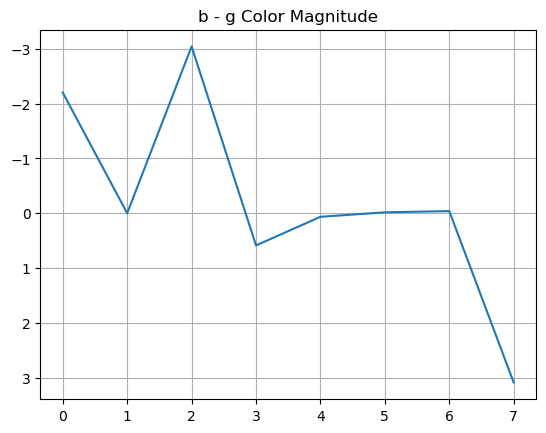

In [61]:
#**************************
# your figure here

color_magnitude = b_mag_calibrated - g_mag_calibrated #calculates b-g color magnitude

plt.gca().invert_yaxis()
plt.grid(True)
plt.plot(color_magnitude)
plt.title("b - g Color Magnitude")

## Problem 8 - Summarize the CMD (6 points)
Write about the main features of the H-R diagram that you see.  Note that we have not selected members and that there may be contaminants in this field.  I would like you to point out what you think are the astrophysically meaningful regions of this diagram and indicate stars to highlight your points.   If you wish to draw on your figure to annotate it, save the figure and load it into another program, like google slides, to draw on it.

Given that the B and V bands each have their own magnitude limit, describe mathematically the faintest magnitude you see at every color. 


**put answer here:**